# 0. Setup stuff

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray as xr
import seaborn as sns
import cartopy.crs as ccrs
from matplotlib import rcParams

In [2]:
# Set up default plotting style: https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
plt.style.use('seaborn-v0_8-notebook')

In [3]:
# Set some rc parameters: https://matplotlib.org/stable/users/explain/customizing.html
# https://matplotlib.org/stable/api/matplotlib_configuration_api.html
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 12
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['axes.titlesize'] = 14
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

In [4]:
# Load the sample dataset
ds = xr.tutorial.open_dataset('air_temperature')


# Part 1: Basic Bar Chart with Text Labels

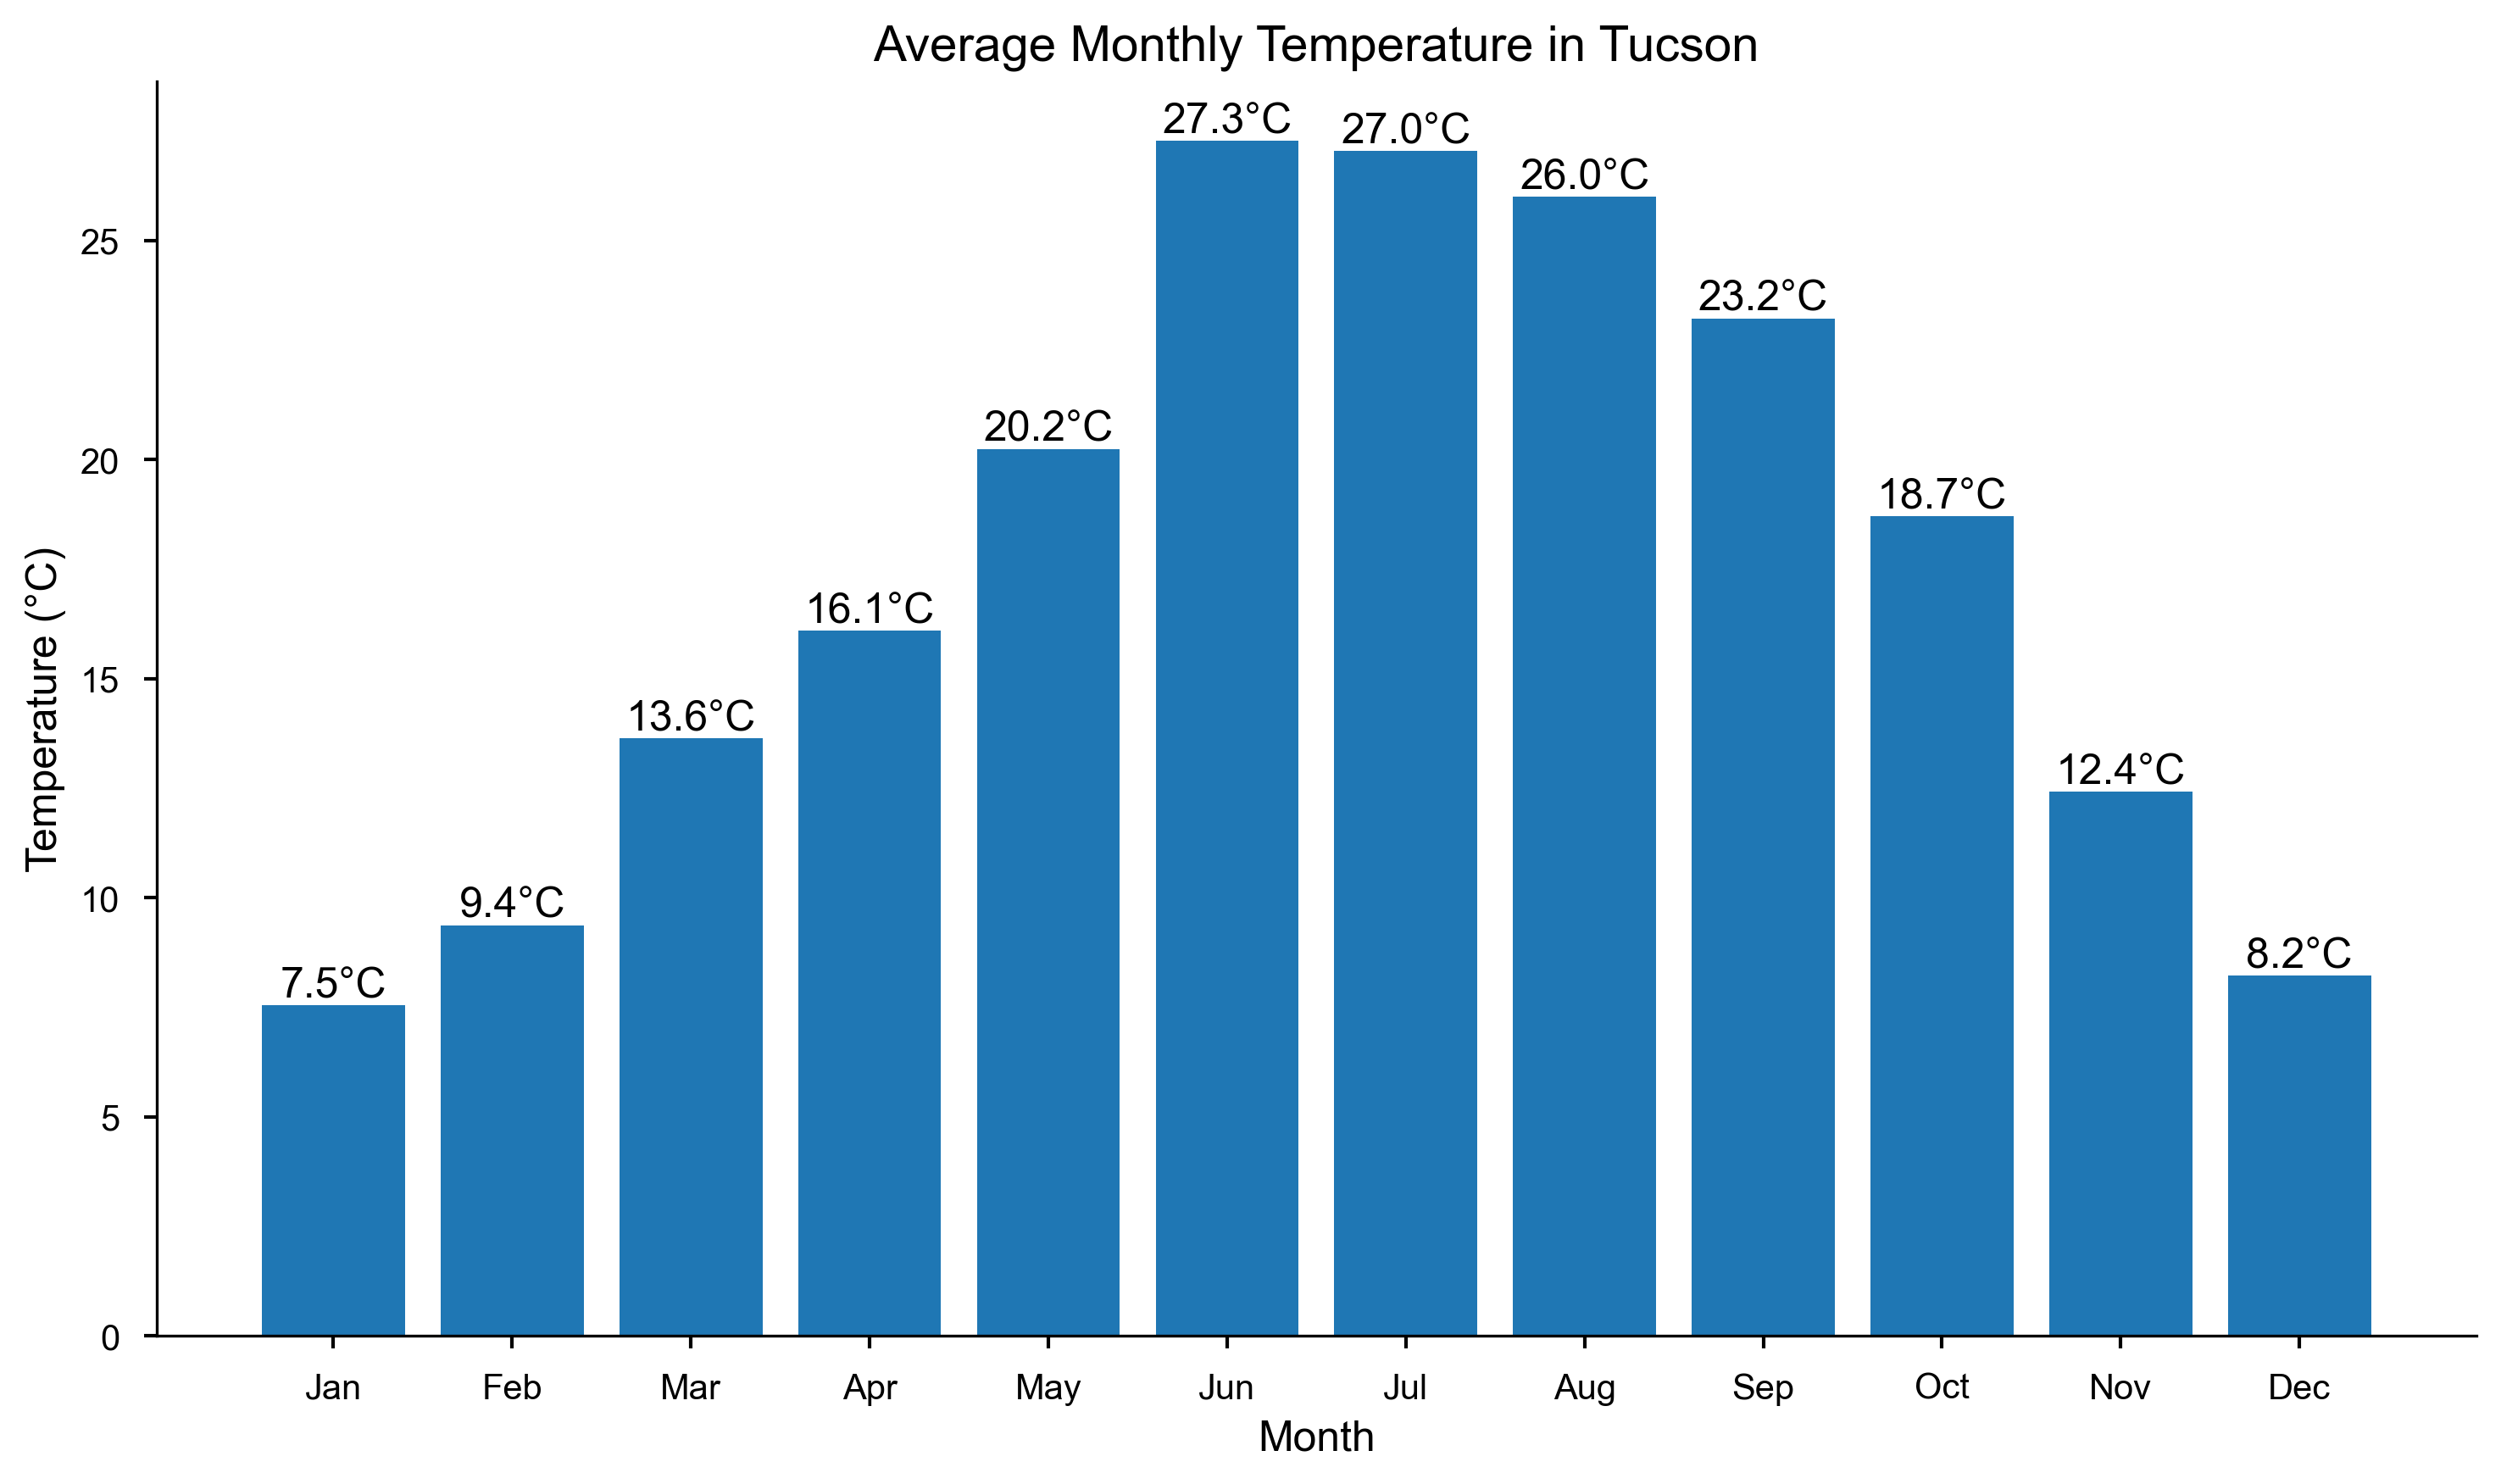

In [5]:
# Select Tucson location and calculate monthly means
tucson_lat, tucson_lon = 32.2540, 360.0 - 110.9742
tucson_temp = ds.sel(lat=tucson_lat, lon=tucson_lon, method='nearest')['air']
monthly_mean = tucson_temp.groupby('time.month').mean()

fig, ax = plt.subplots(figsize=(10, 6))

# Create bar chart
bars = ax.bar(range(1, 13), monthly_mean.values - 273.15)  # Convert to Celsius

# Customize the plot
ax.set_xlabel('Month')
ax.set_ylabel('Temperature (°C)')
ax.set_title('Average Monthly Temperature in Tucson')
ax.set_xticks(range(1, 13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Add text labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}°C',
            ha='center', va='bottom')

# Clean up axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()


# 2. Temperature anomaly plot

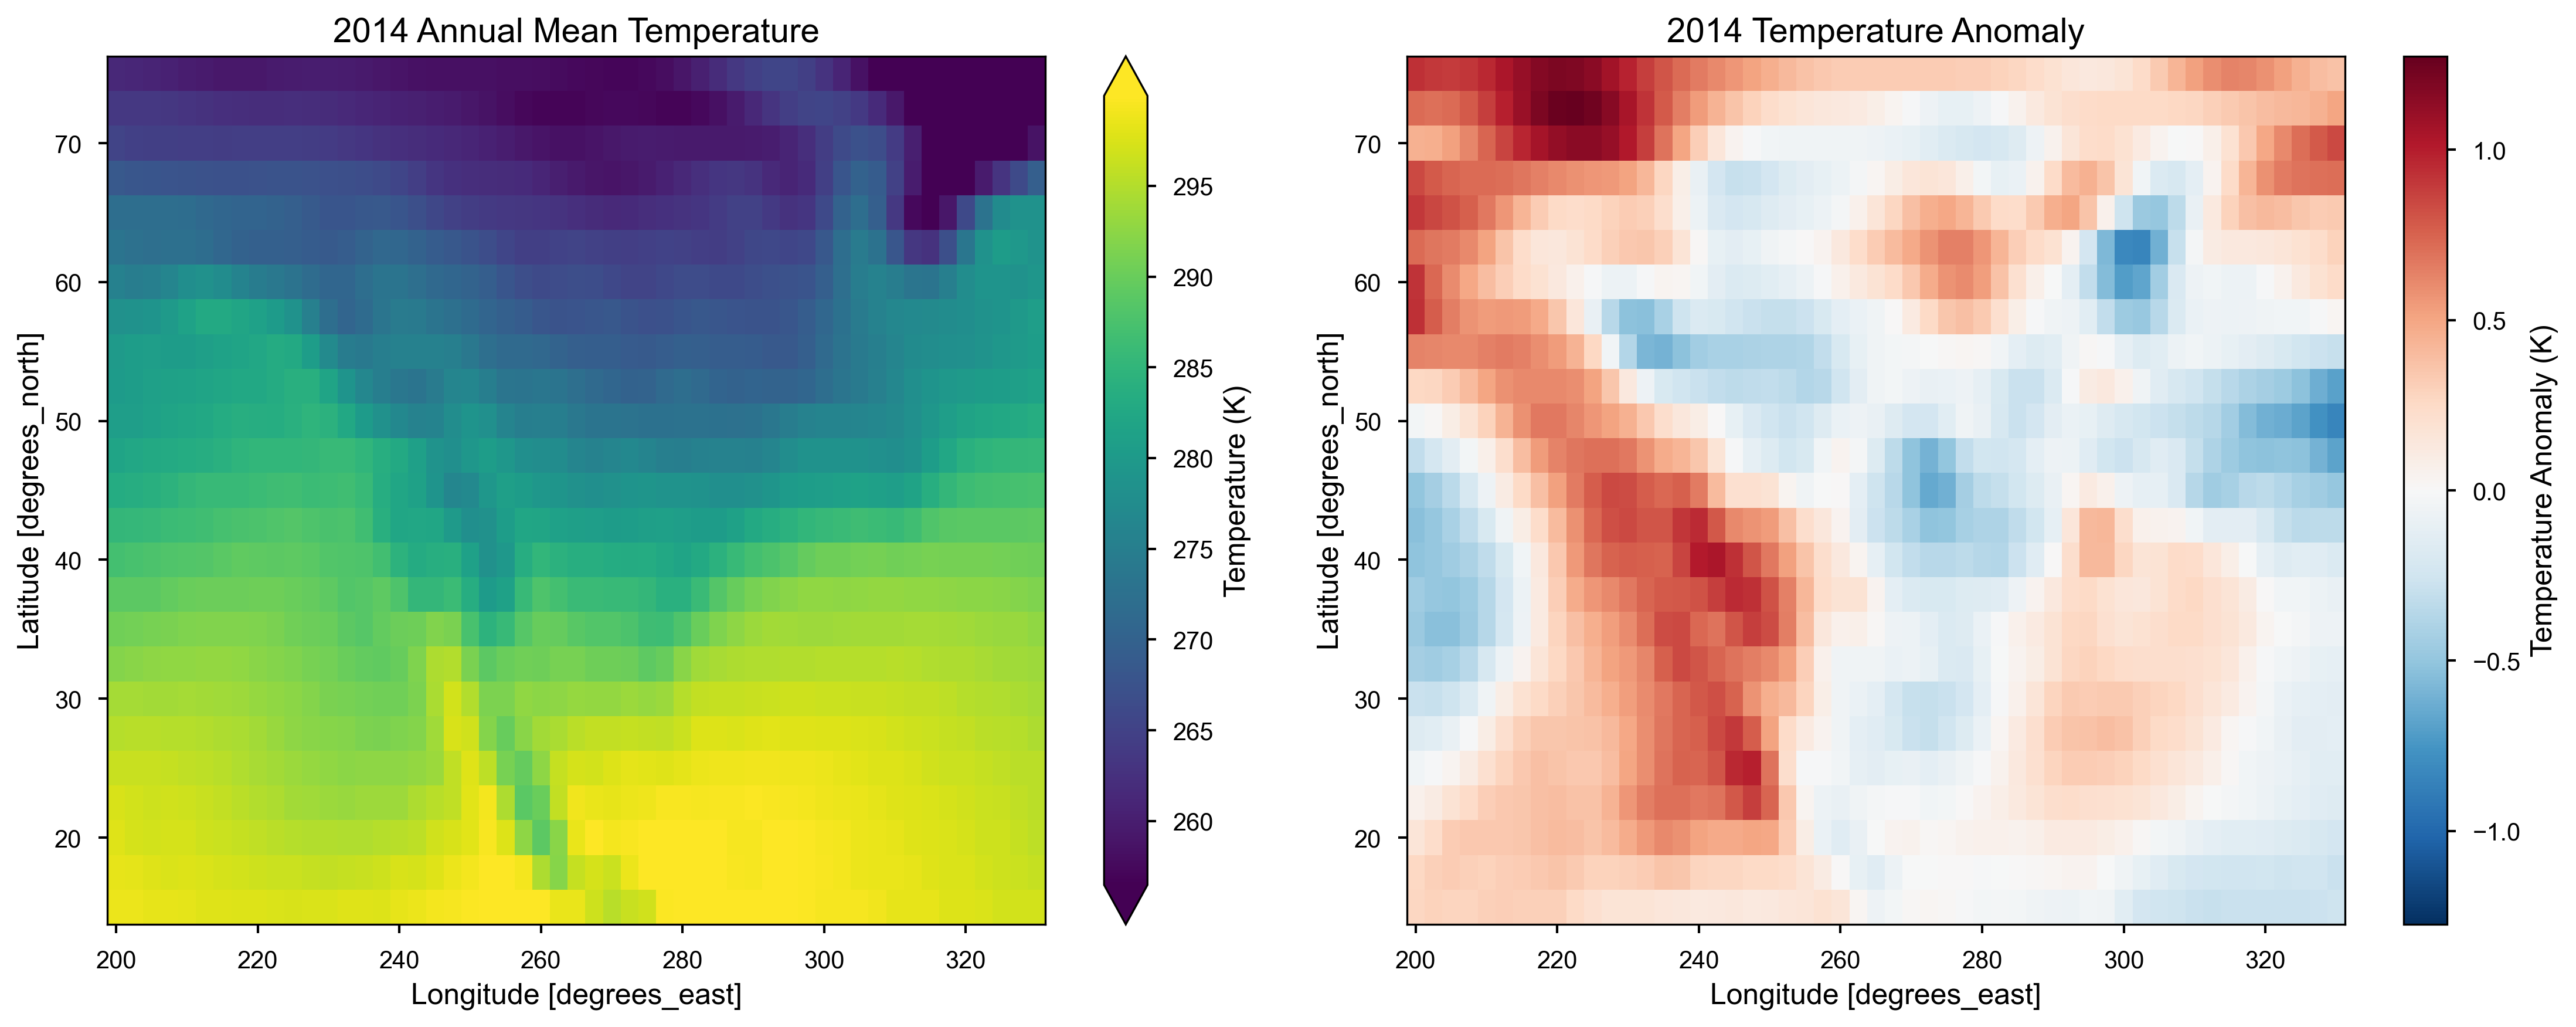

In [7]:
# Calculate temperature anomalies
annual_mean = ds['air'].mean('time')
mean_2014 = ds['air'].sel(time='2014').mean('time')
anomaly = mean_2014 - annual_mean

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot with sequential colormap for absolute temperatures
im1 = mean_2014.plot(
    ax=ax1, 
    cmap='viridis',
    cbar_kwargs={'label': 'Temperature (K)'},
    robust=True
)
ax1.set_title('2014 Annual Mean Temperature')

# Plot with diverging colormap for anomalies
im2 = anomaly.plot(
    ax=ax2,
    cmap='RdBu_r',  # Diverging colormap
    cbar_kwargs={'label': 'Temperature Anomaly (K)'},
    center=0  # Center the colormap at zero
)
ax2.set_title('2014 Temperature Anomaly')

plt.tight_layout()


# 3. Facet grid plot (small multiples)

/var/folders/7c/k9ztpxkn35s1mbm2kjthjwz80000gn/T/ipykernel_94767/2897285975.py:15: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for i, ax in enumerate(facet_grid.axes.flat):


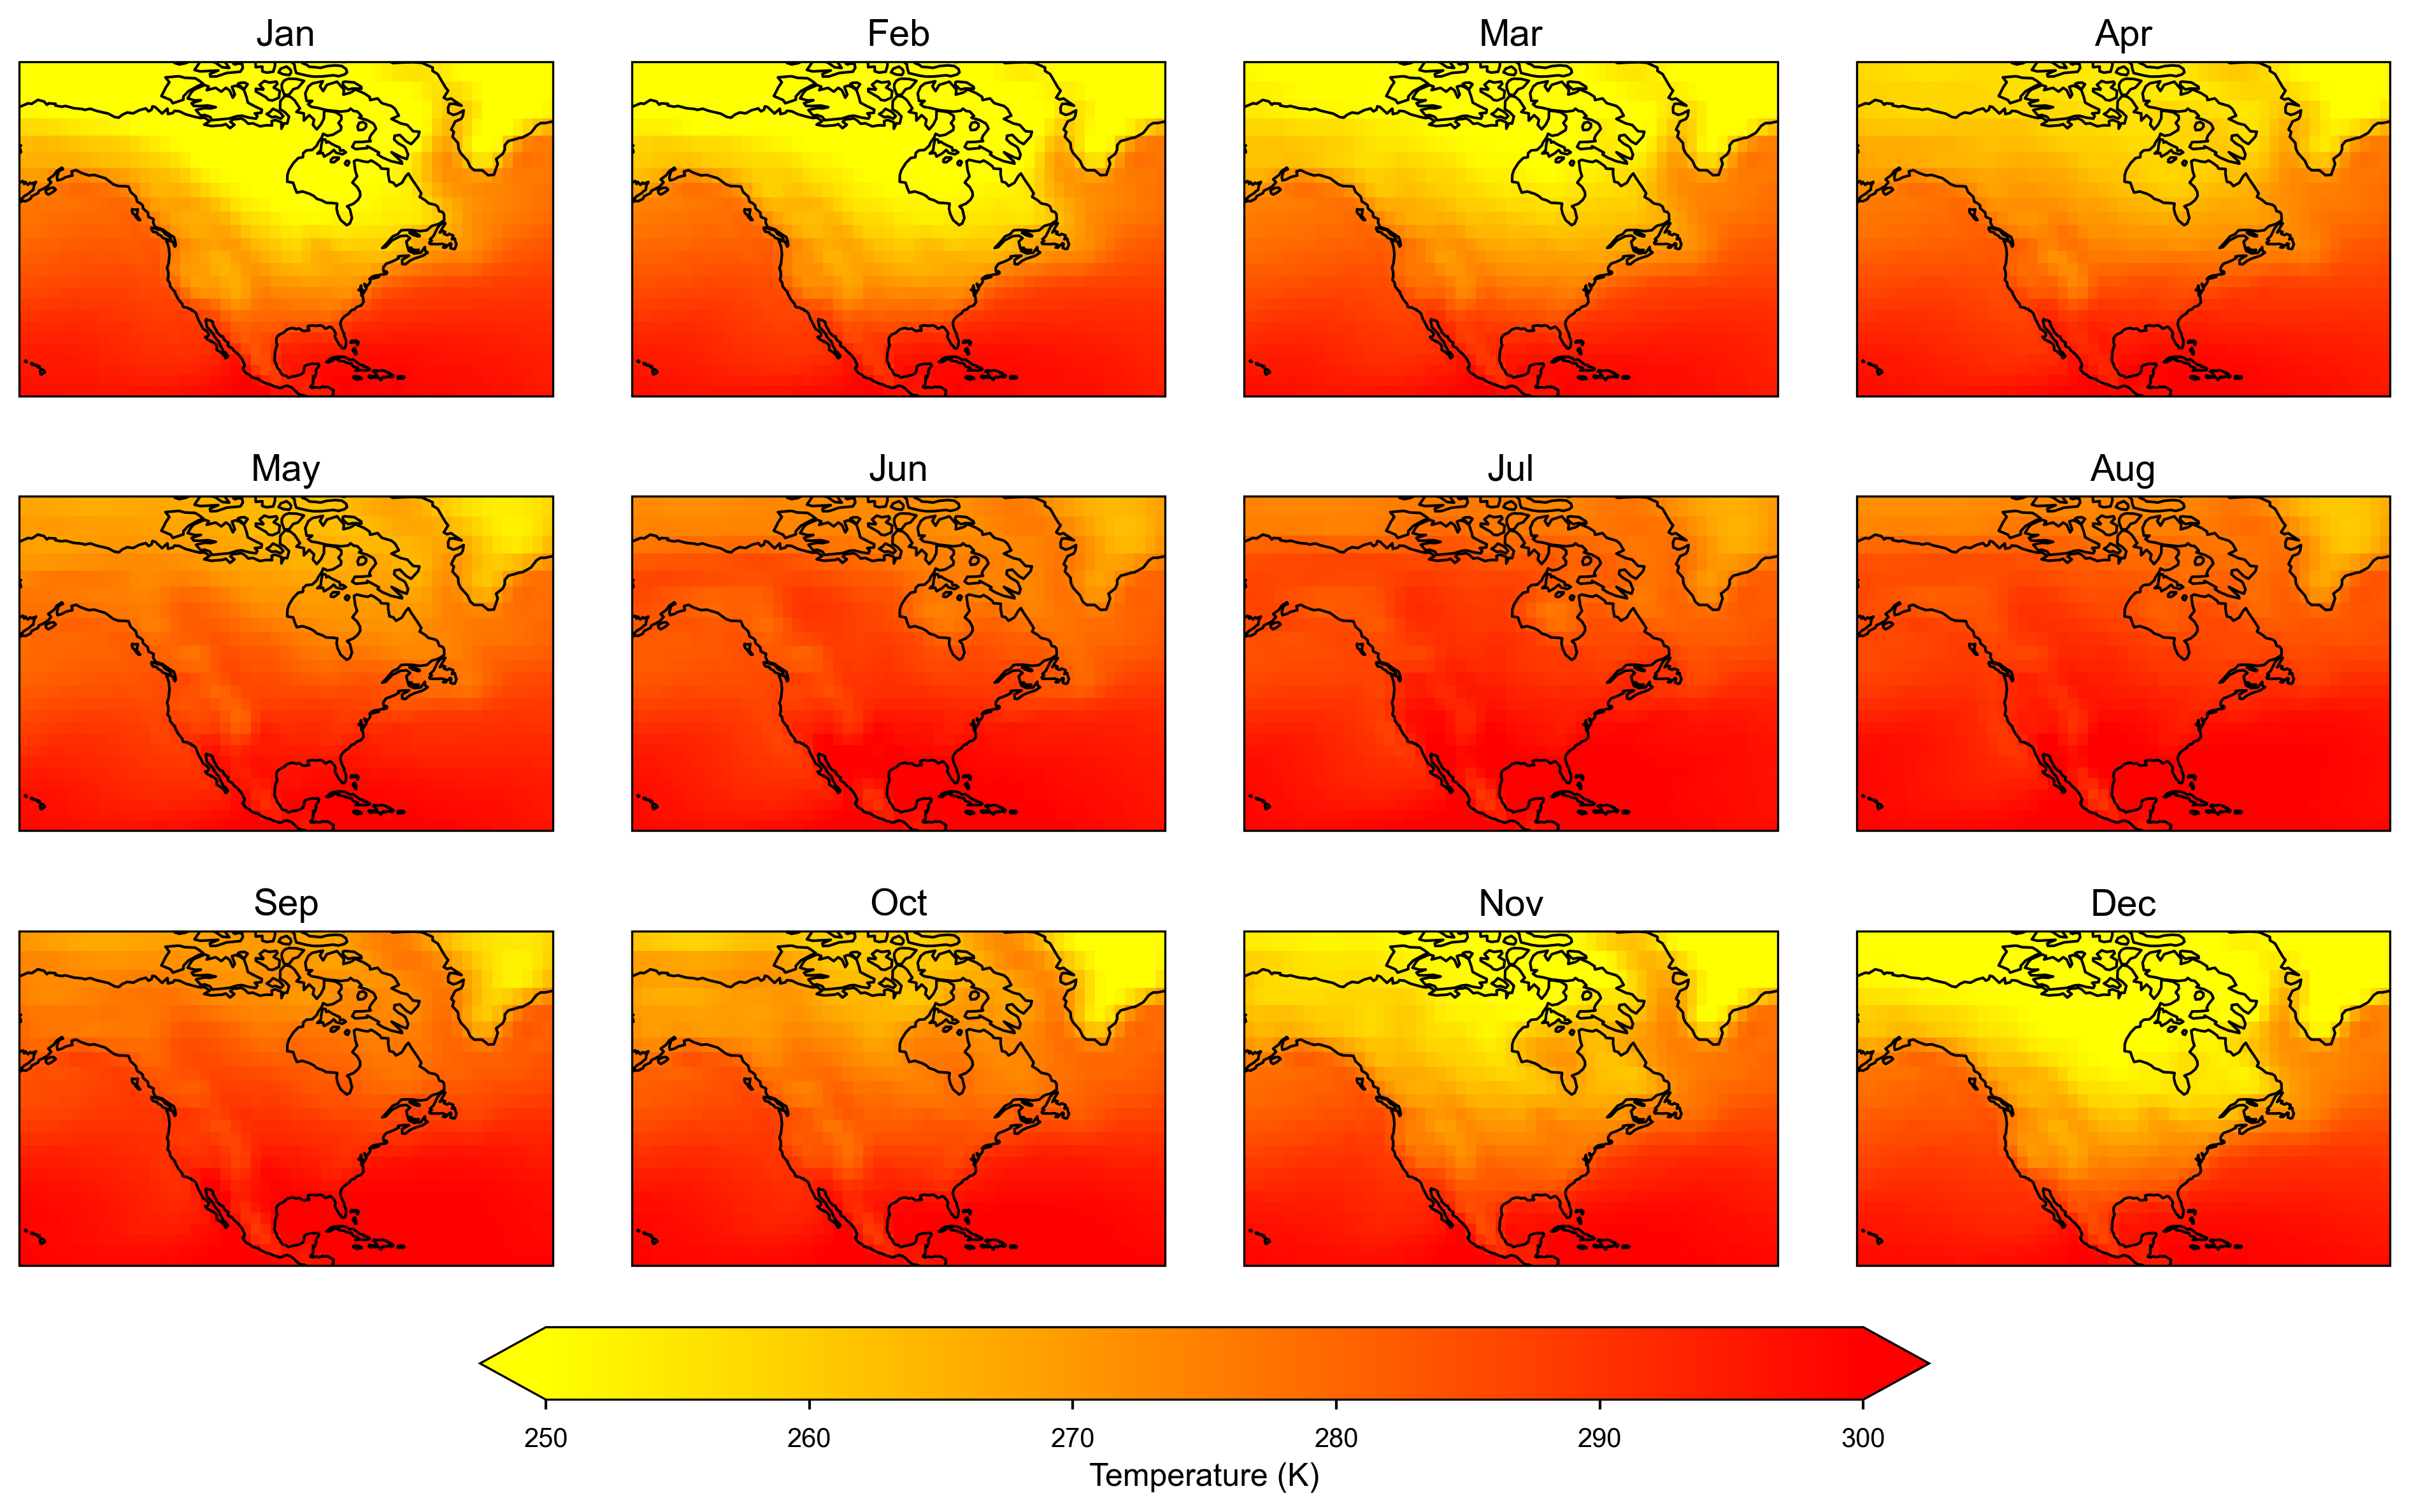

In [119]:
# Calculate monthly means
monthly_mean = ds['air'].groupby('time.month').mean('time')
facet_grid = monthly_mean.plot(
    x='lon', y='lat', col='month', col_wrap=4, cmap='autumn_r',
    vmin=250, vmax=300,  
    transform=ccrs.PlateCarree(), 
    subplot_kws={'projection': ccrs.Miller()},
    cbar_kwargs={'label': 'Temperature (K)', 'orientation': 'horizontal', 'shrink': 0.6},
)
months = [
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
]
for i, ax in enumerate(facet_grid.axes.flat):
    ax.set_title(months[i])
    ax.coastlines(linewidth=1)

plt.subplots_adjust(bottom=0.2, top=0.9, hspace=0.3)  # Adjust the spacing

# 4. Time series with moving average

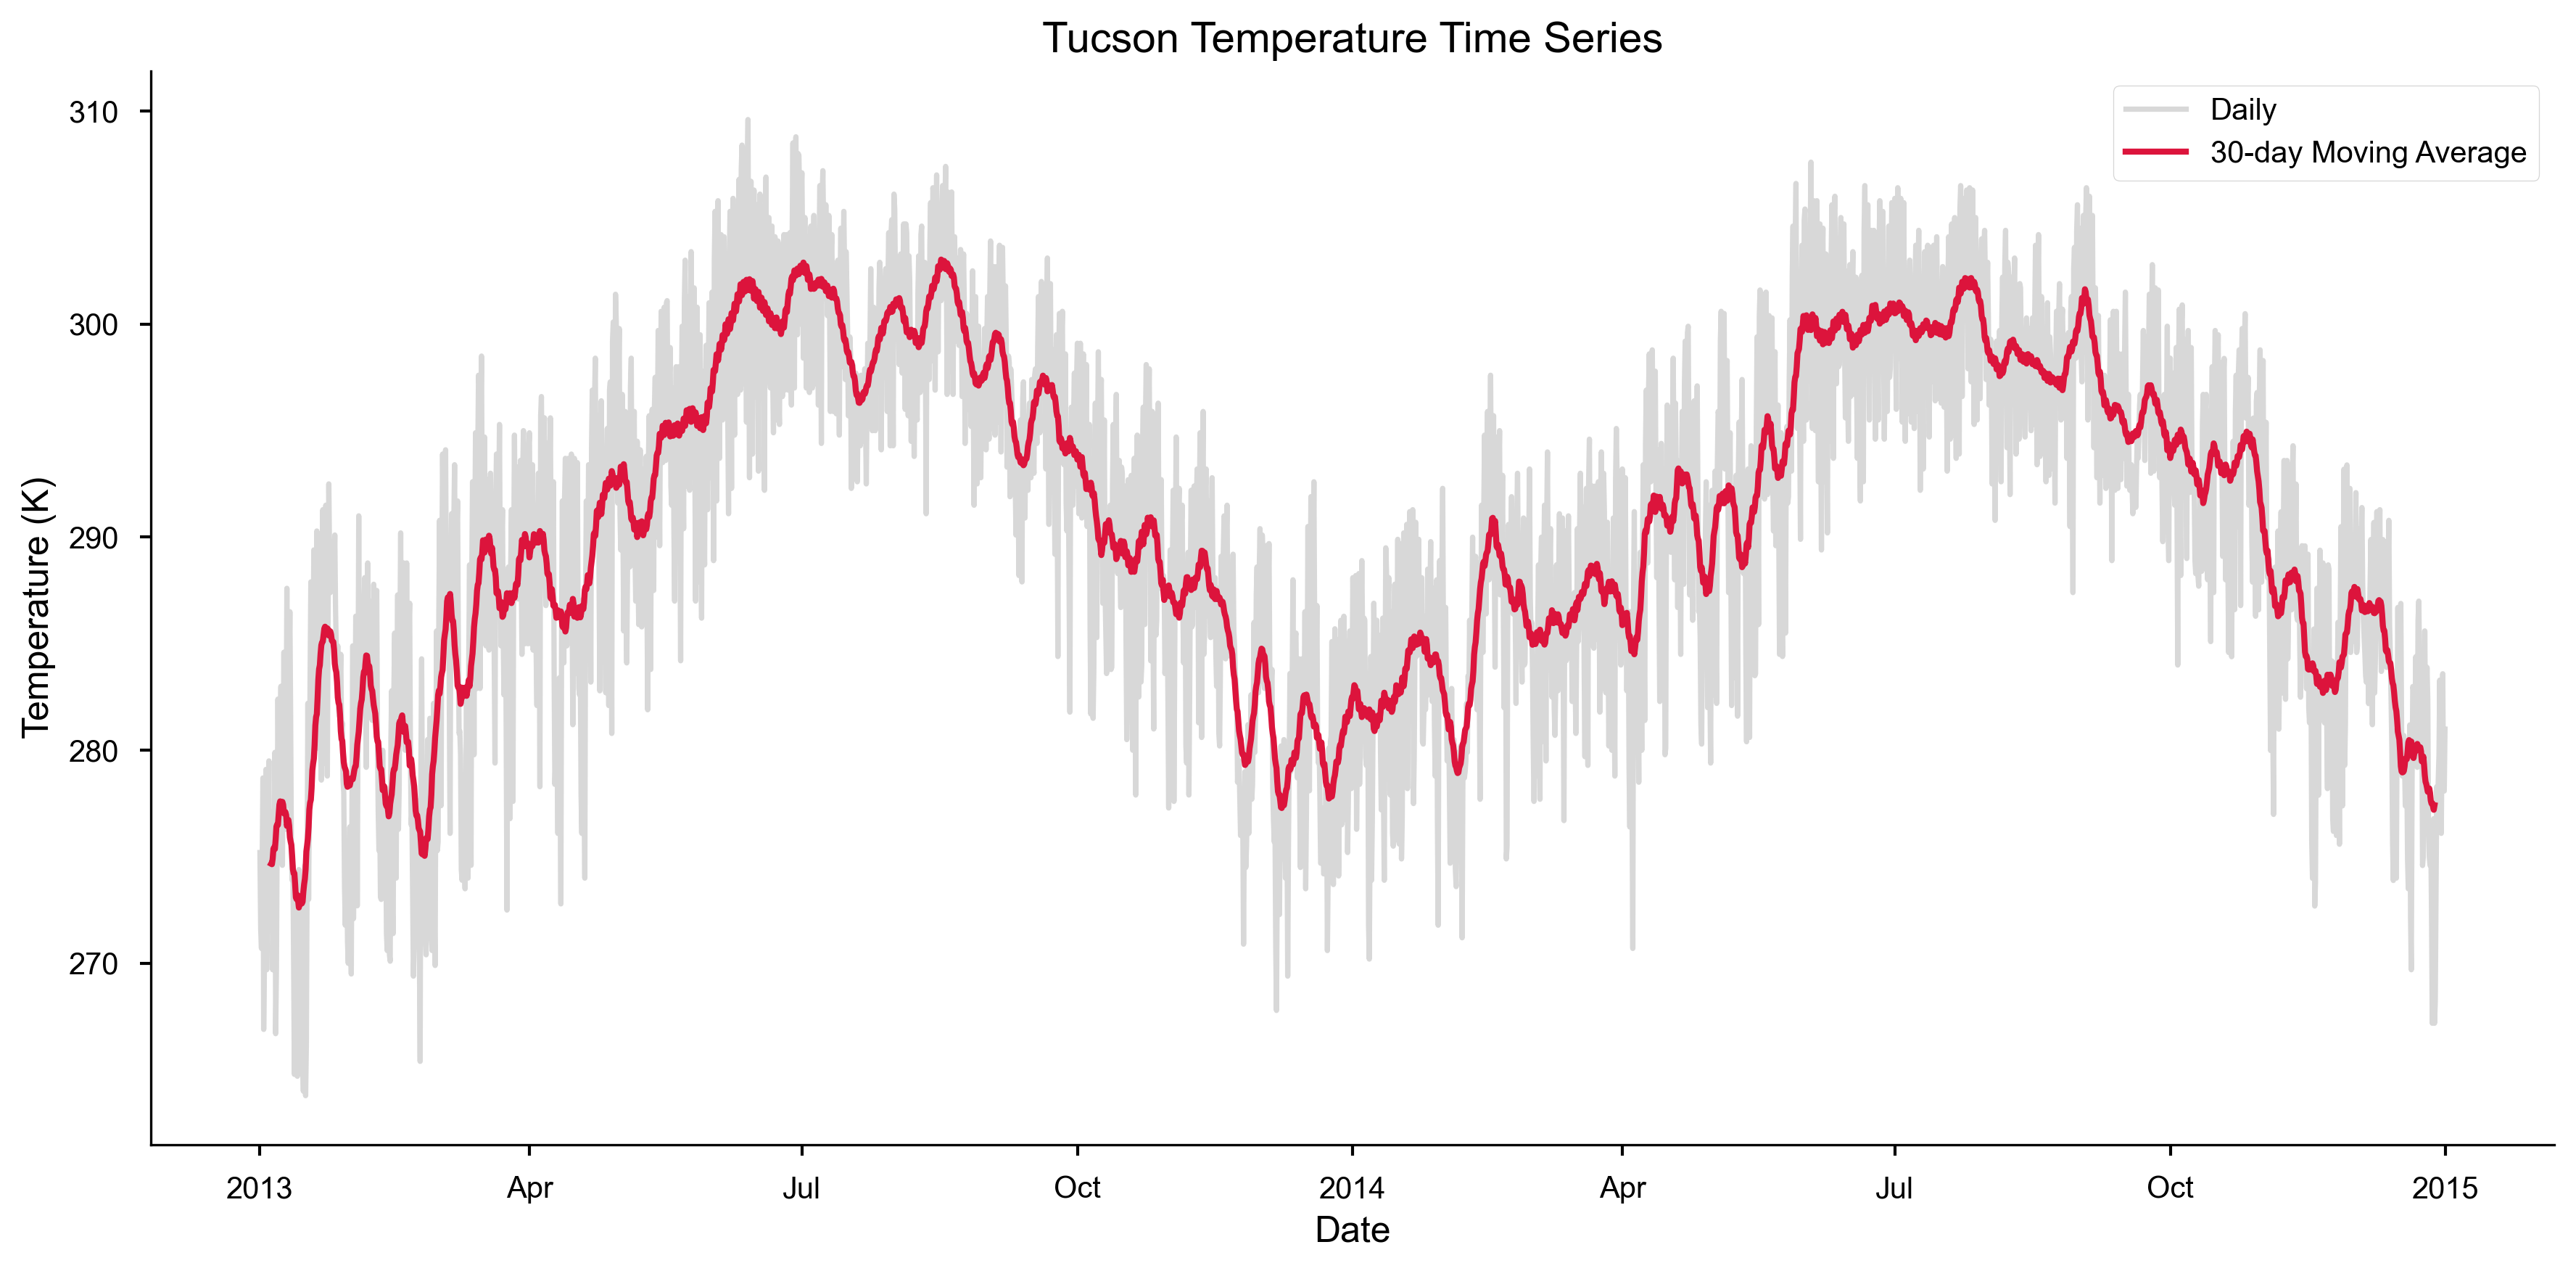

In [8]:
tucson_temp = ds.sel(lat=tucson_lat, lon=tucson_lon, method='nearest')['air']

fig, ax = plt.subplots(figsize=(12, 6))

# Plot raw data
tucson_temp.plot(ax=ax, alpha=0.3, color='gray', label='Daily')

# Plot 30-day moving average
tucson_temp.rolling(time=30, center=True).mean().plot(
    ax=ax, 
    color='crimson', 
    linewidth=2,
    label='30-day Moving Average'
)

ax.set_title('Tucson Temperature Time Series')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (K)')
ax.legend()

# Clean up axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()


# 5. Monthly box plots

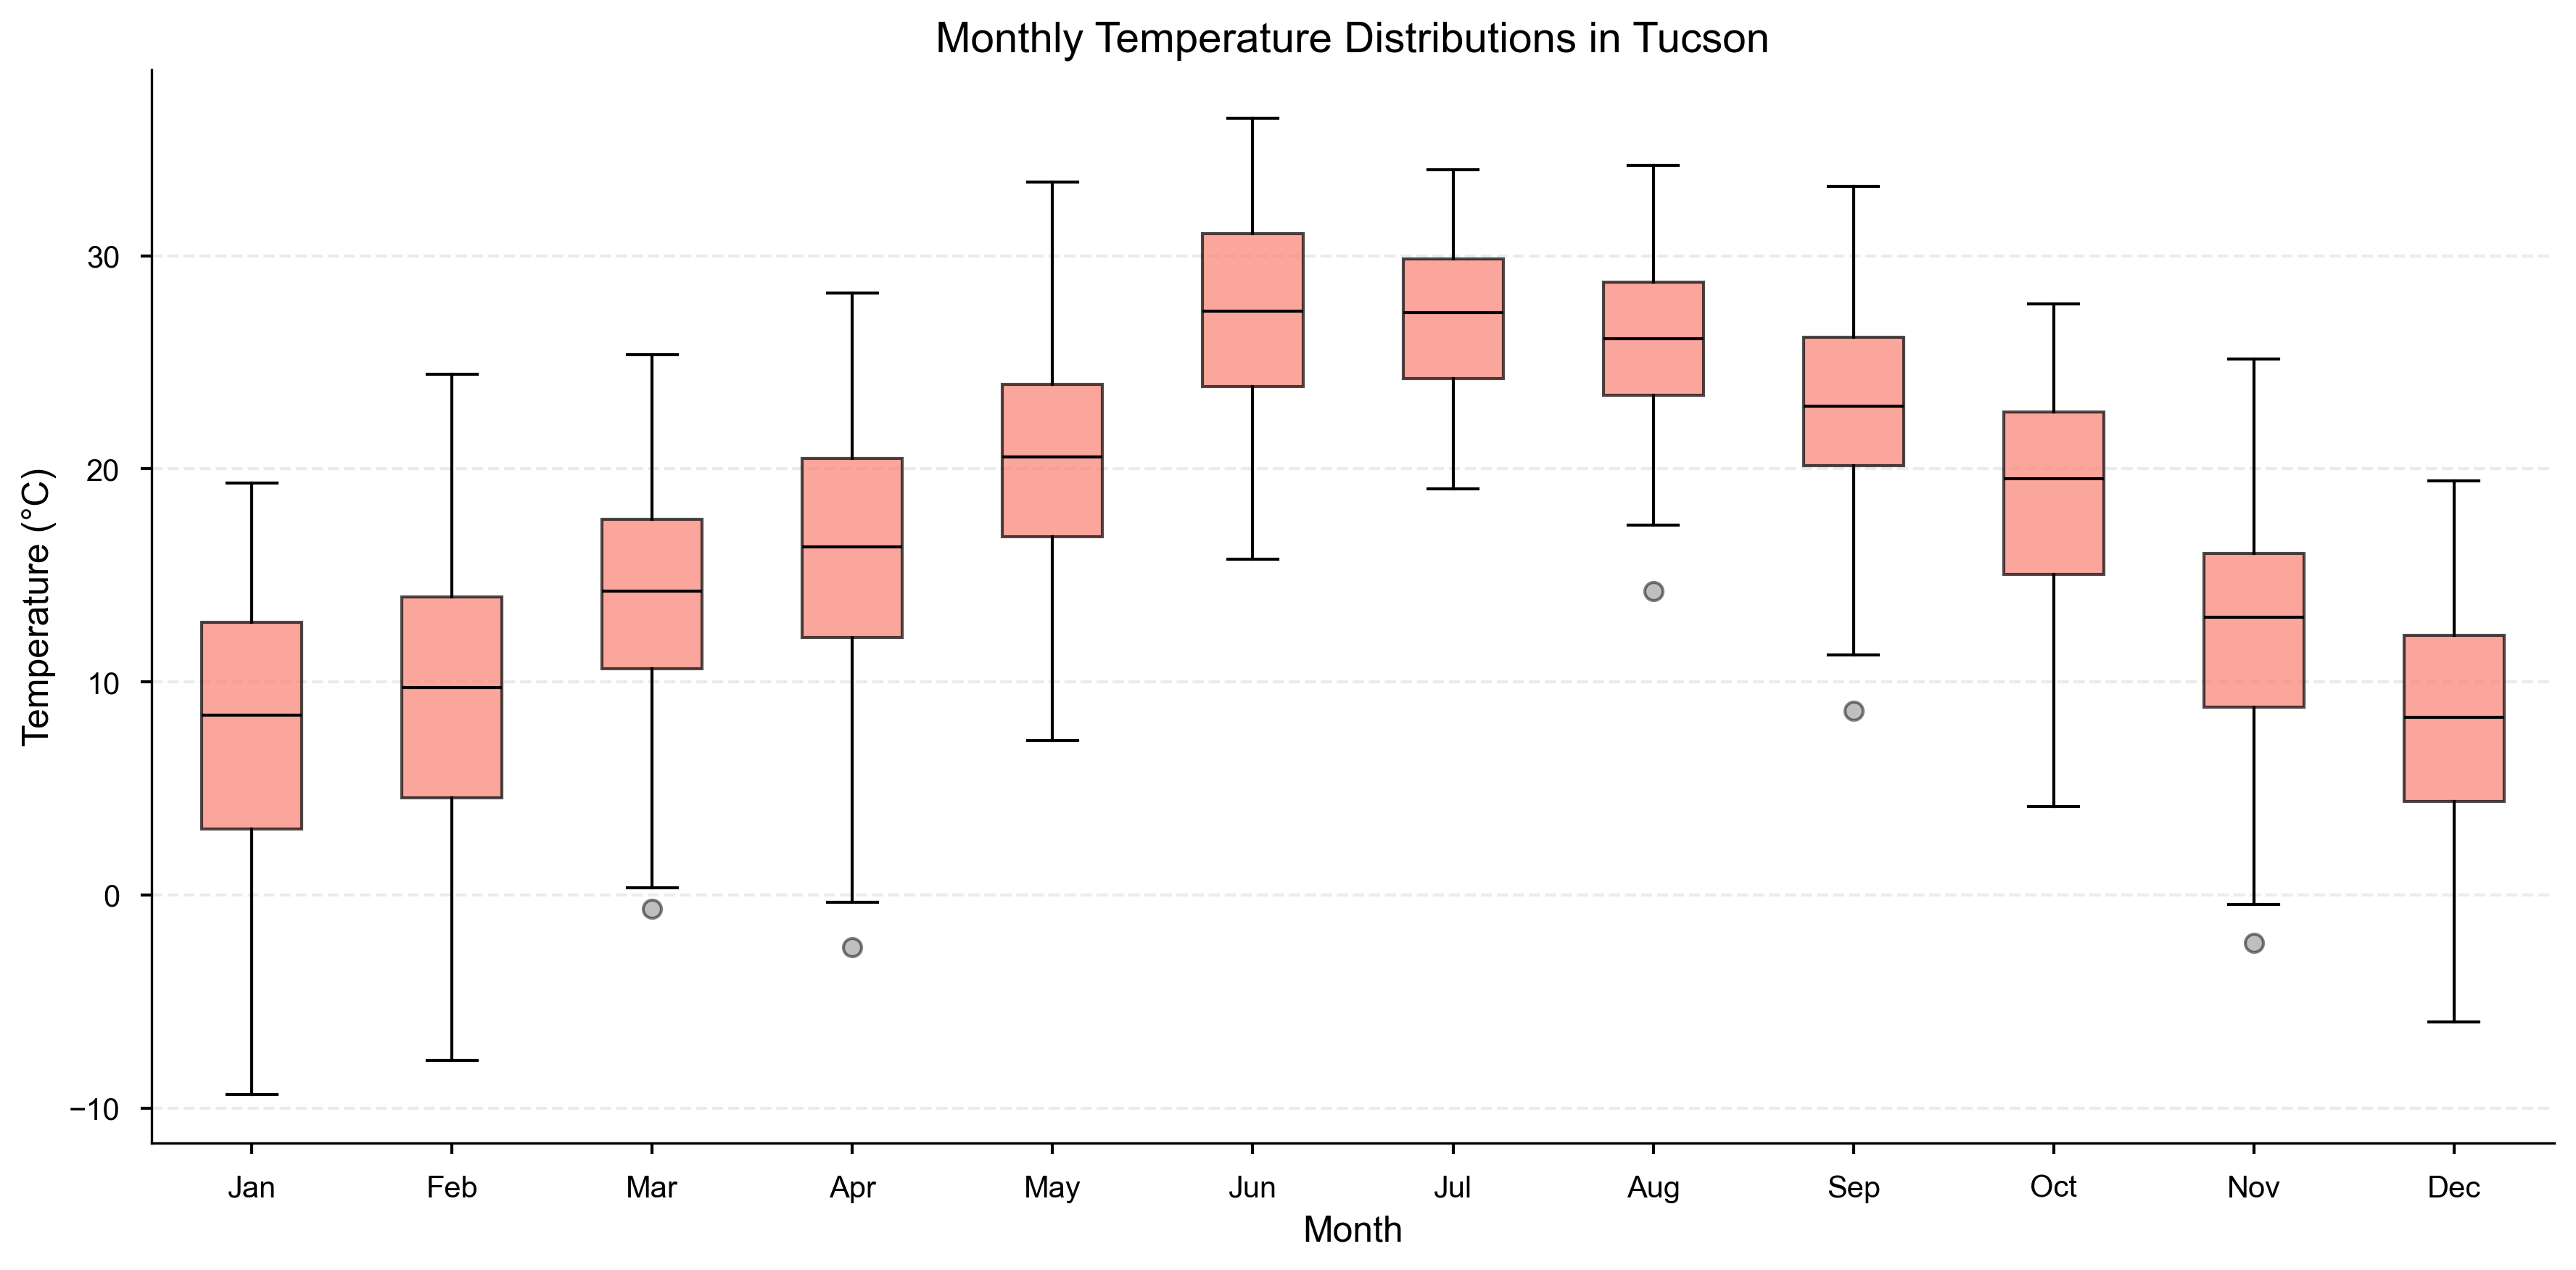

In [129]:
# Group data by month but keep all values
monthly_grouped = tucson_temp.groupby('time.month')

# Convert temperatures to Celsius for plotting
monthly_data = [(month, temps.values - 273.15) for month, temps in monthly_grouped]

fig, ax = plt.subplots(figsize=(12, 6))

# Create box plot
bp = ax.boxplot([temps for _, temps in monthly_data],
                patch_artist=True,  # Fill boxes with color
                medianprops={'color': 'black'},  # Black median lines
                flierprops={'marker': 'o',  # Outlier formatting
                          'markerfacecolor': 'gray',
                          'alpha': 0.5})

# Customize box colors
for box in bp['boxes']:
    box.set(facecolor='salmon', alpha=0.7)

# Customize the plot
ax.set_xlabel('Month')
ax.set_ylabel('Temperature (°C)')
ax.set_title('Monthly Temperature Distributions in Tucson')
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Clean up axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add subtle horizontal lines from y-axis
ax.yaxis.grid(True, linestyle='--', alpha=0.25)

plt.tight_layout()

# 6. Grouped monthly box plots for 2 locations

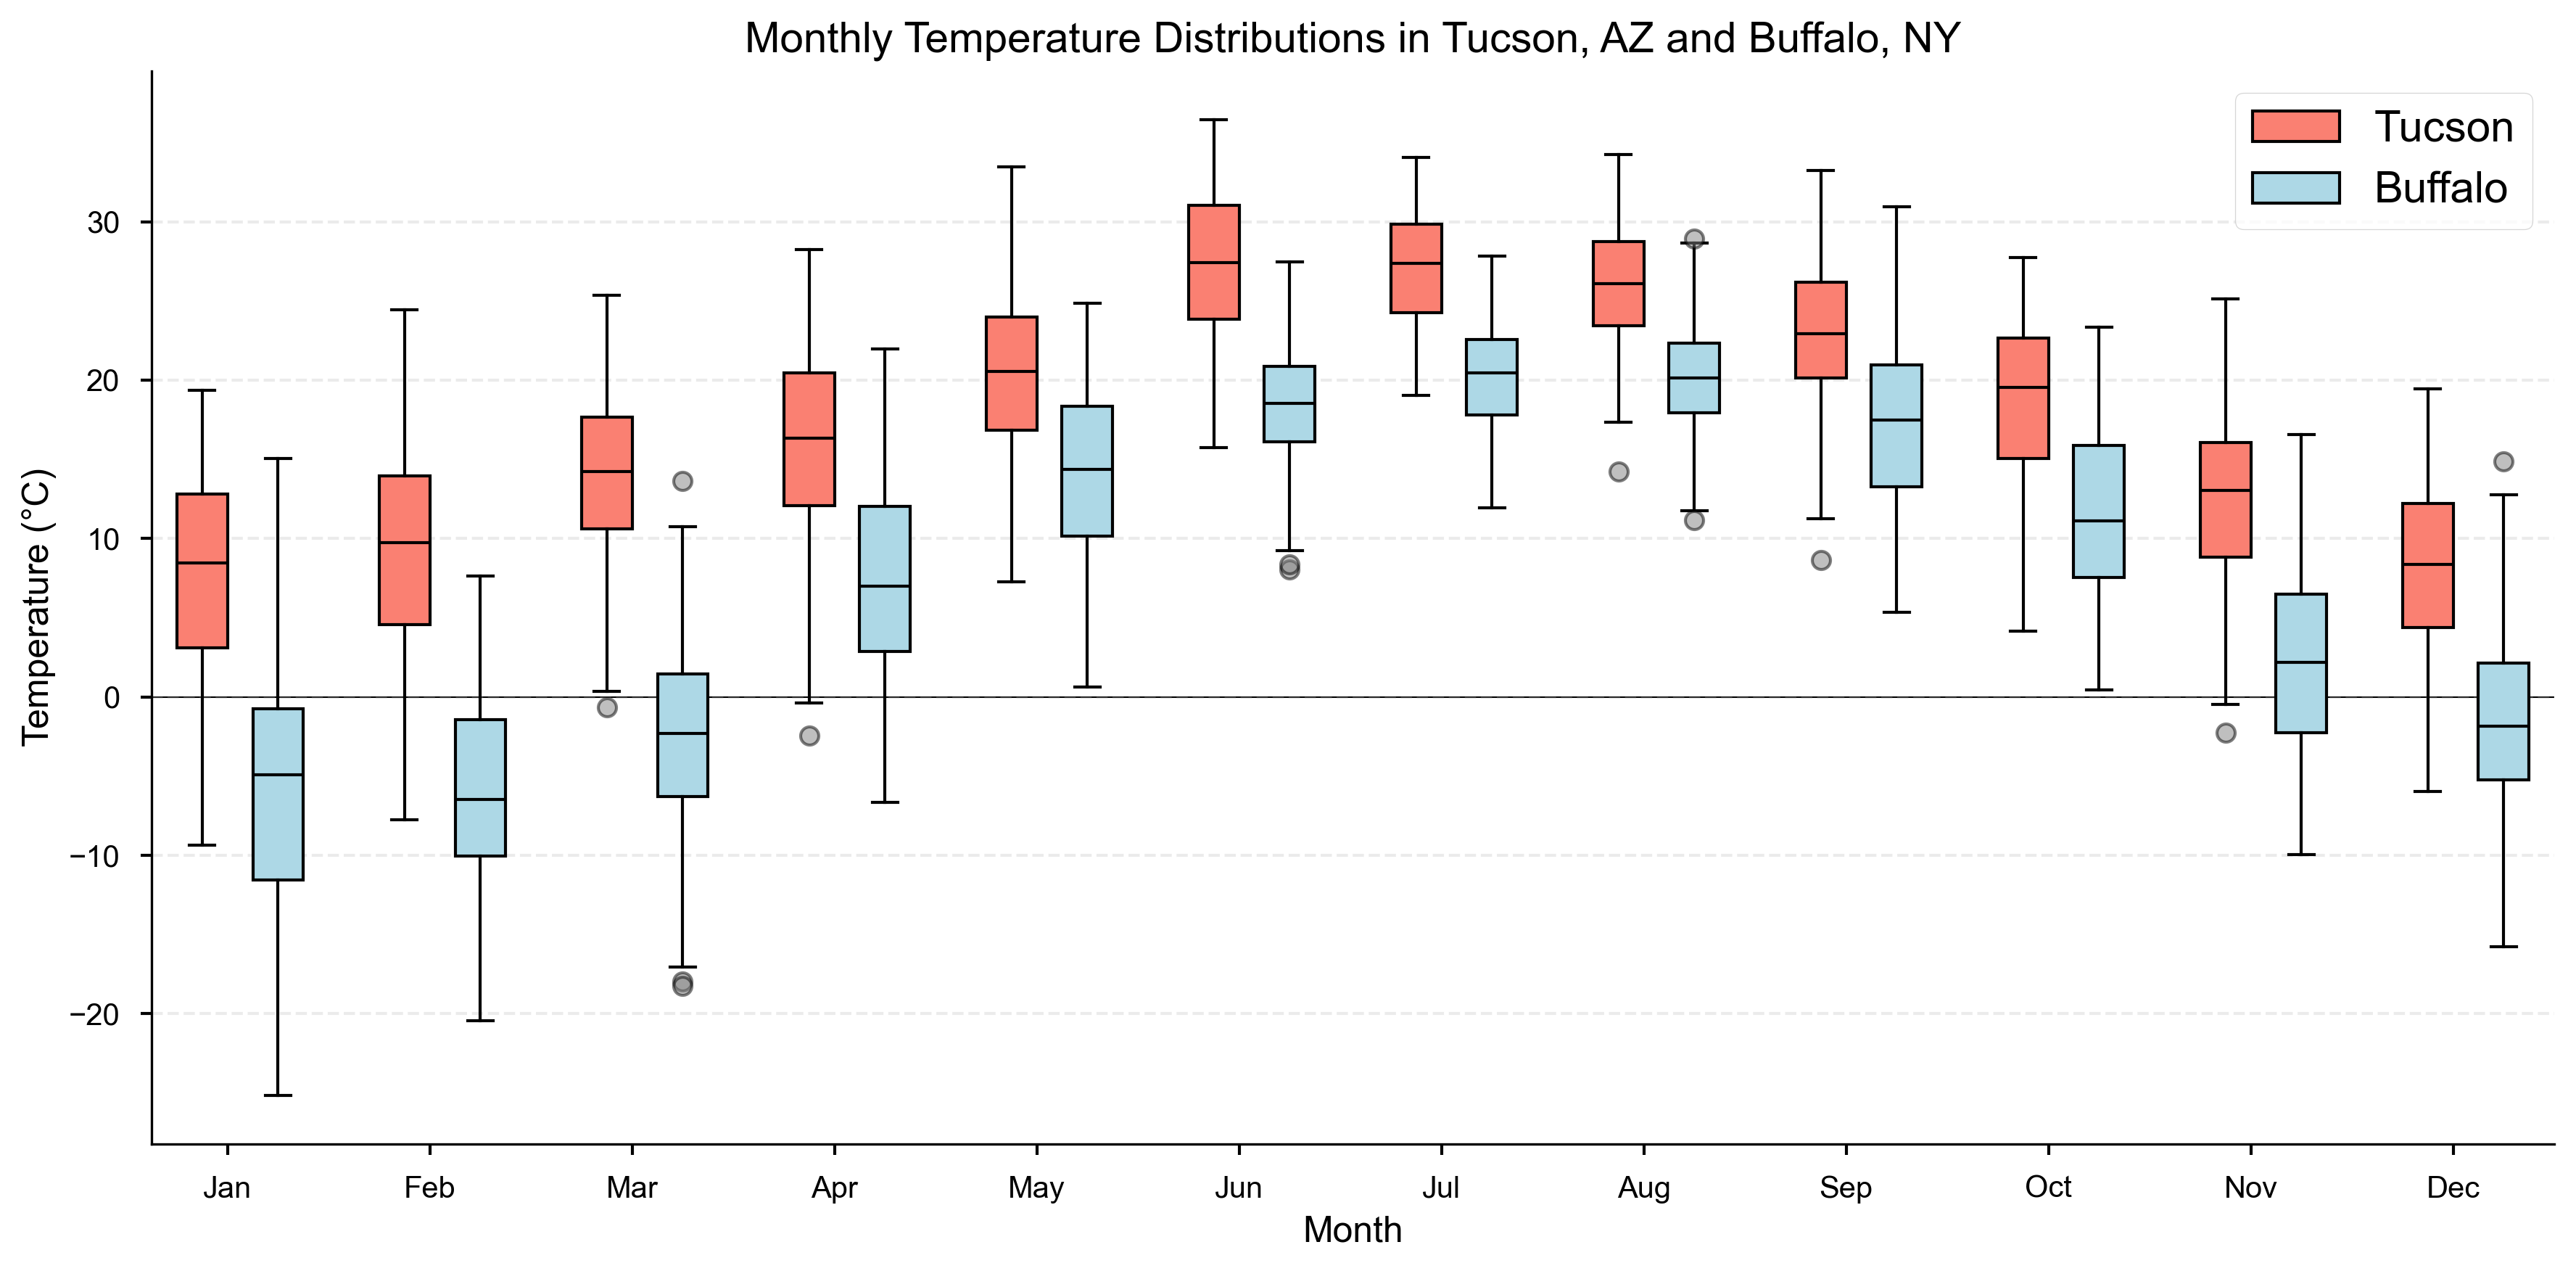

In [128]:
# Select temperature data for Tucson and Buffalo
tucson_lat, tucson_lon = 32.25, -110.97  # Tucson coordinates
buffalo_lat, buffalo_lon = 42.88, -78.87  # Buffalo coordinates

# Convert lon from 0 to 360 format to -180 to 180
tucson_lon = (tucson_lon + 360) % 360
buffalo_lon = (buffalo_lon + 360) % 360

# Extract temperature time series for Tucson and Buffalo
tucson_temp = ds['air'].sel(lat=tucson_lat, lon=tucson_lon, method='nearest')
buffalo_temp = ds['air'].sel(lat=buffalo_lat, lon=buffalo_lon, method='nearest')

# Group data by month for both locations
tucson_grouped = tucson_temp.groupby('time.month')
buffalo_grouped = buffalo_temp.groupby('time.month')

# Convert temperatures to Celsius for plotting
tucson_data = [(month, temps.values - 273.15) for month, temps in tucson_grouped]
buffalo_data = [(month, temps.values - 273.15) for month, temps in buffalo_grouped]

# Prepare the figure
fig, ax = plt.subplots(figsize=(12, 6))

# Plot Tucson boxplots
tucson_positions = np.arange(1, 25, 2) +0.25  # Positions for Tucson boxplots (odd numbers)
bp_tucson = ax.boxplot(
    [temps for _, temps in tucson_data],
    positions=tucson_positions,
    patch_artist=True,
    medianprops={'color': 'black'},
    flierprops={'marker': 'o', 'markerfacecolor': 'gray', 'alpha': 0.5},
    boxprops={'facecolor': 'salmon'}
)

# Plot Buffalo boxplots in the next step
buffalo_positions = tucson_positions + 0.75  # Positions for Buffalo boxplots (even numbers)
bp_buffalo = ax.boxplot(
    [temps for _, temps in buffalo_data],
    positions=buffalo_positions,  
    patch_artist=True,  
    medianprops={'color': 'black'},  
    flierprops={'marker': 'o', 'markerfacecolor': 'gray', 'alpha': 0.5},
    boxprops={'facecolor': 'lightblue',}
)  

# Customize the plot
ax.set_xlabel('Month')
ax.set_ylabel('Temperature (°C)')
ax.set_title('Monthly Temperature Distributions in Tucson, AZ and Buffalo, NY')
ax.set_xticks(np.arange(1.5, 25, 2))  # Center the labels between the two boxplots
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Clean up axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add subtle horizontal lines from y-axis
ax.yaxis.grid(True, linestyle='--', alpha=0.25)
ax.axhline(0, color='black', linewidth=0.5, zorder=-1)  # Add horizontal line at 0

# Add legend to differentiate Tucson and Buffalo
plt.legend(
    [bp_tucson["boxes"][0], bp_buffalo["boxes"][0]], 
    ['Tucson', 'Buffalo'], 
    loc='upper right',
    fontsize='large'
)

plt.tight_layout()
plt.show()



# 7. Filled contour plots

In [55]:
rasm_ds = xr.tutorial.load_dataset('rasm')
# Select a specific time slice for the contour plot
sds = rasm_ds.isel(time=0)

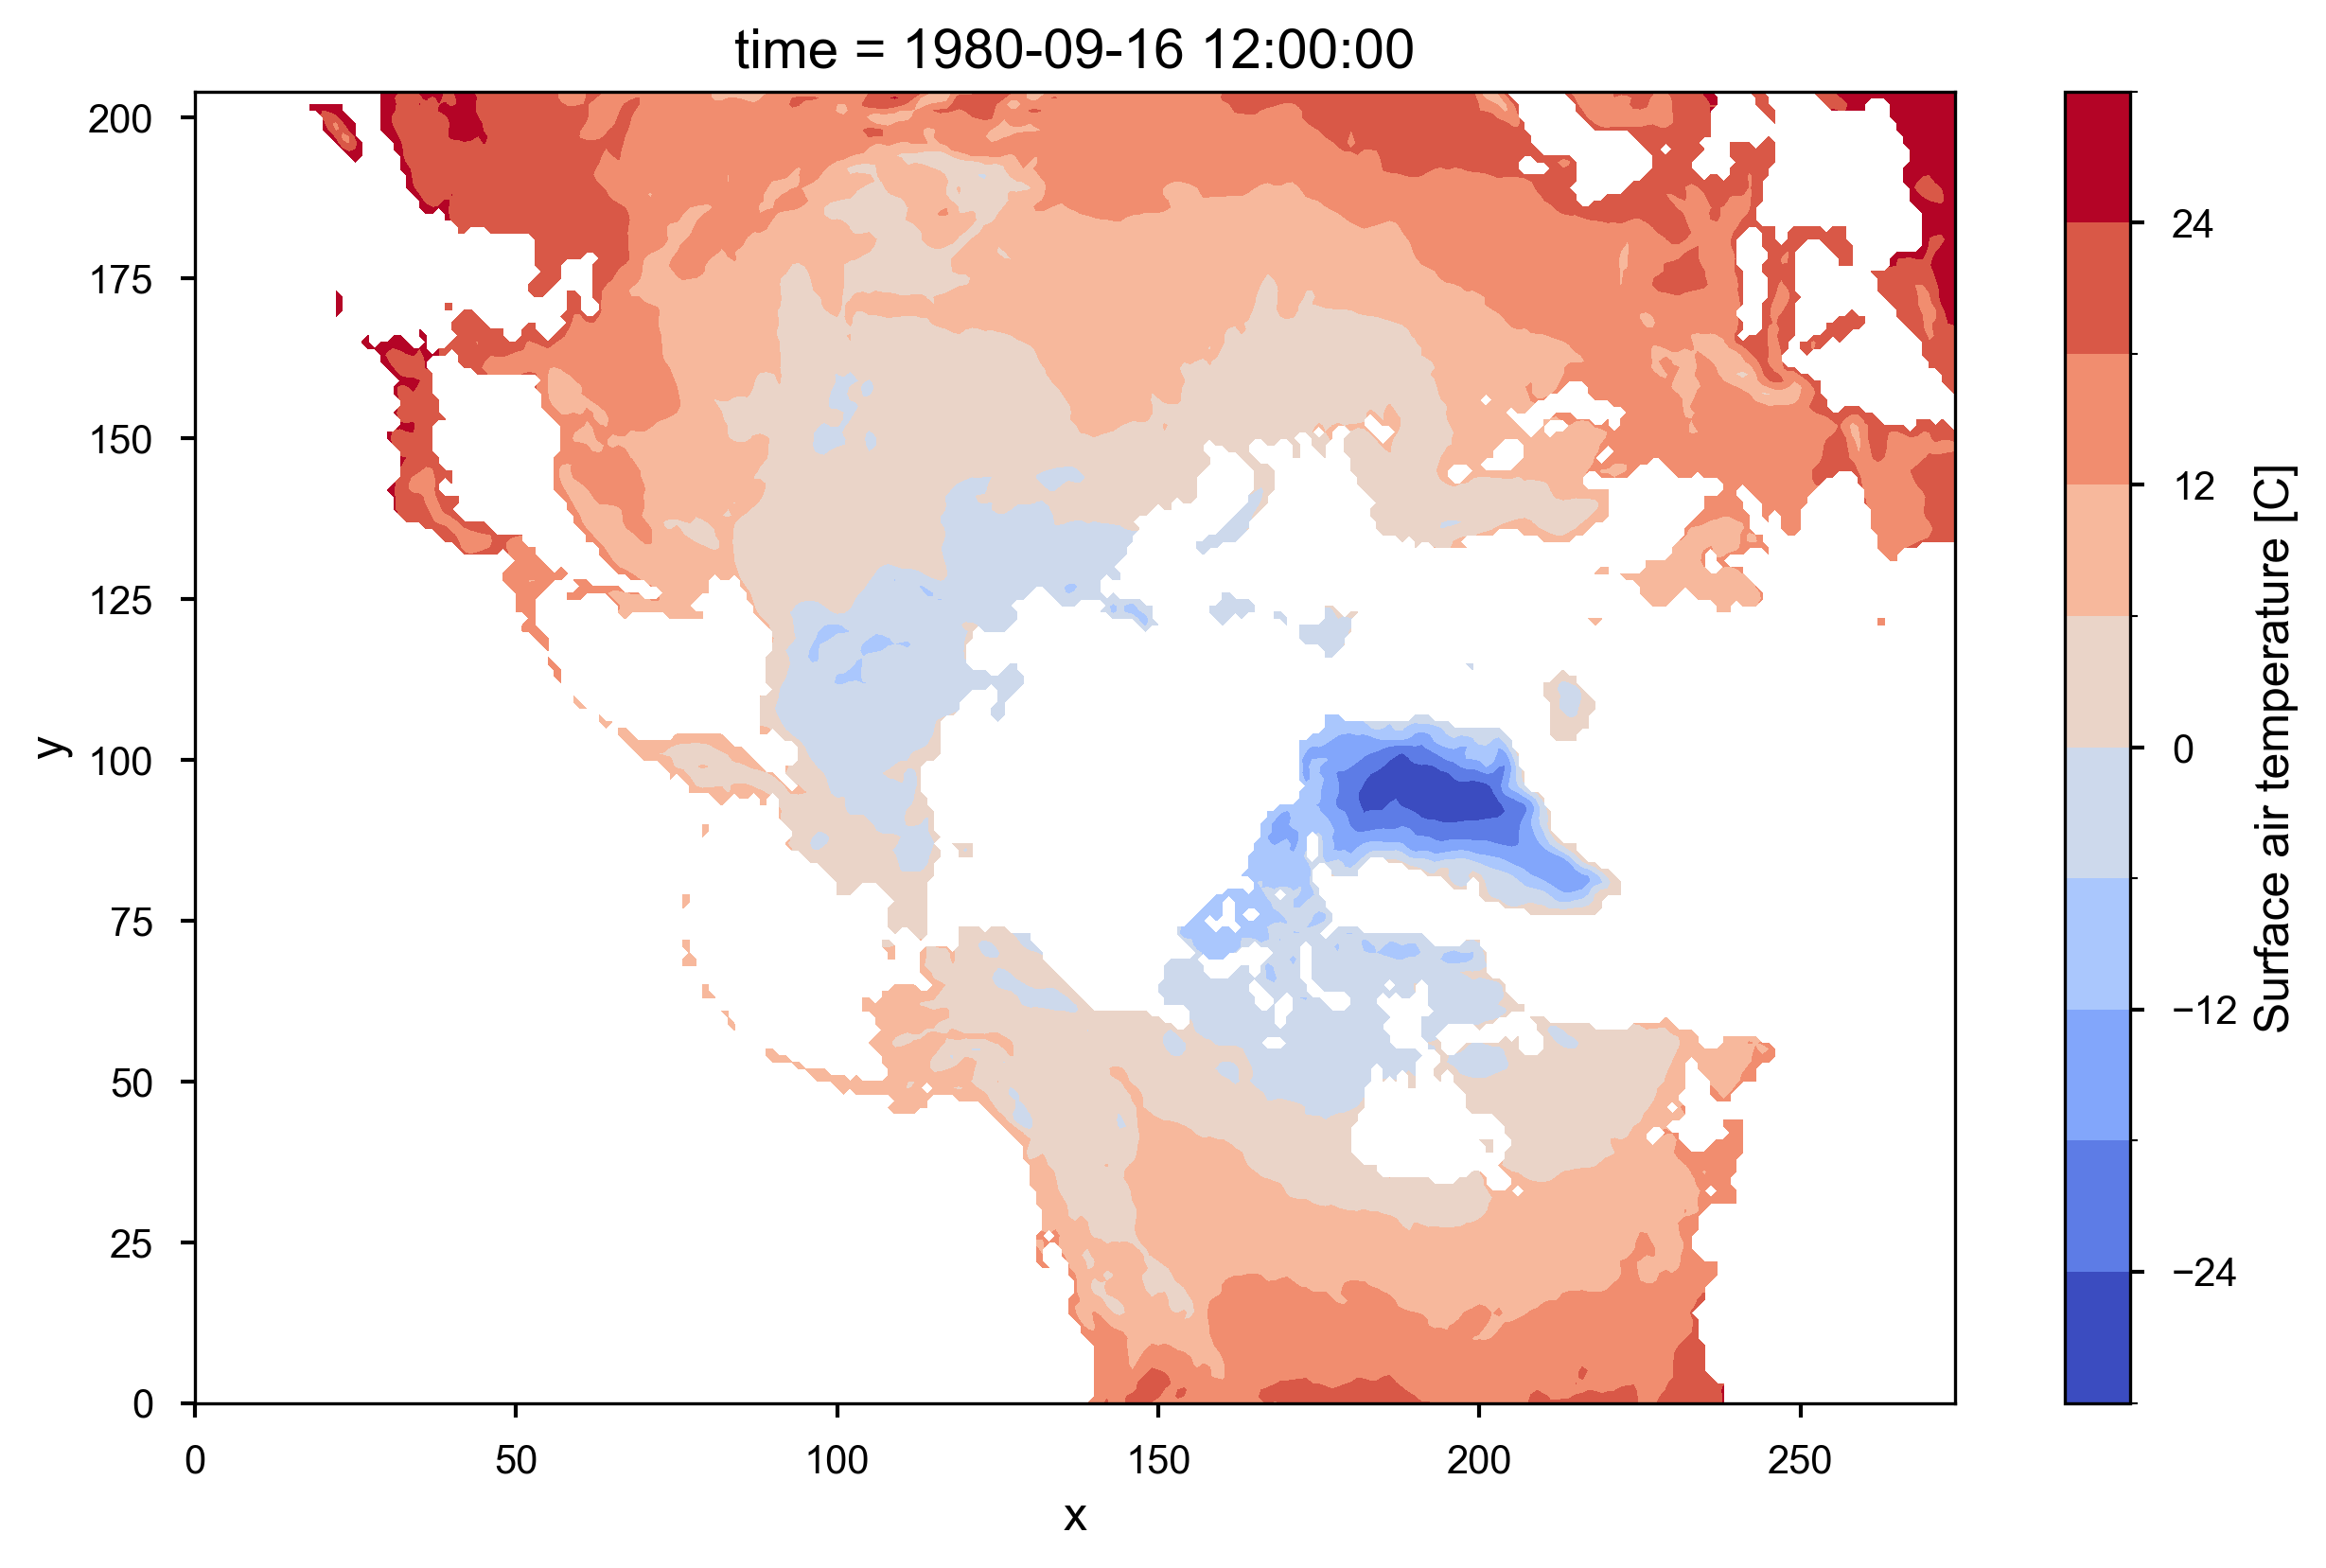

In [69]:
fig, ax = plt.subplots(figsize=(10, 6))
sds['Tair'].plot.contourf(ax=ax, levels=12, cmap='coolwarm')

# 8. Customizing cartopy maps

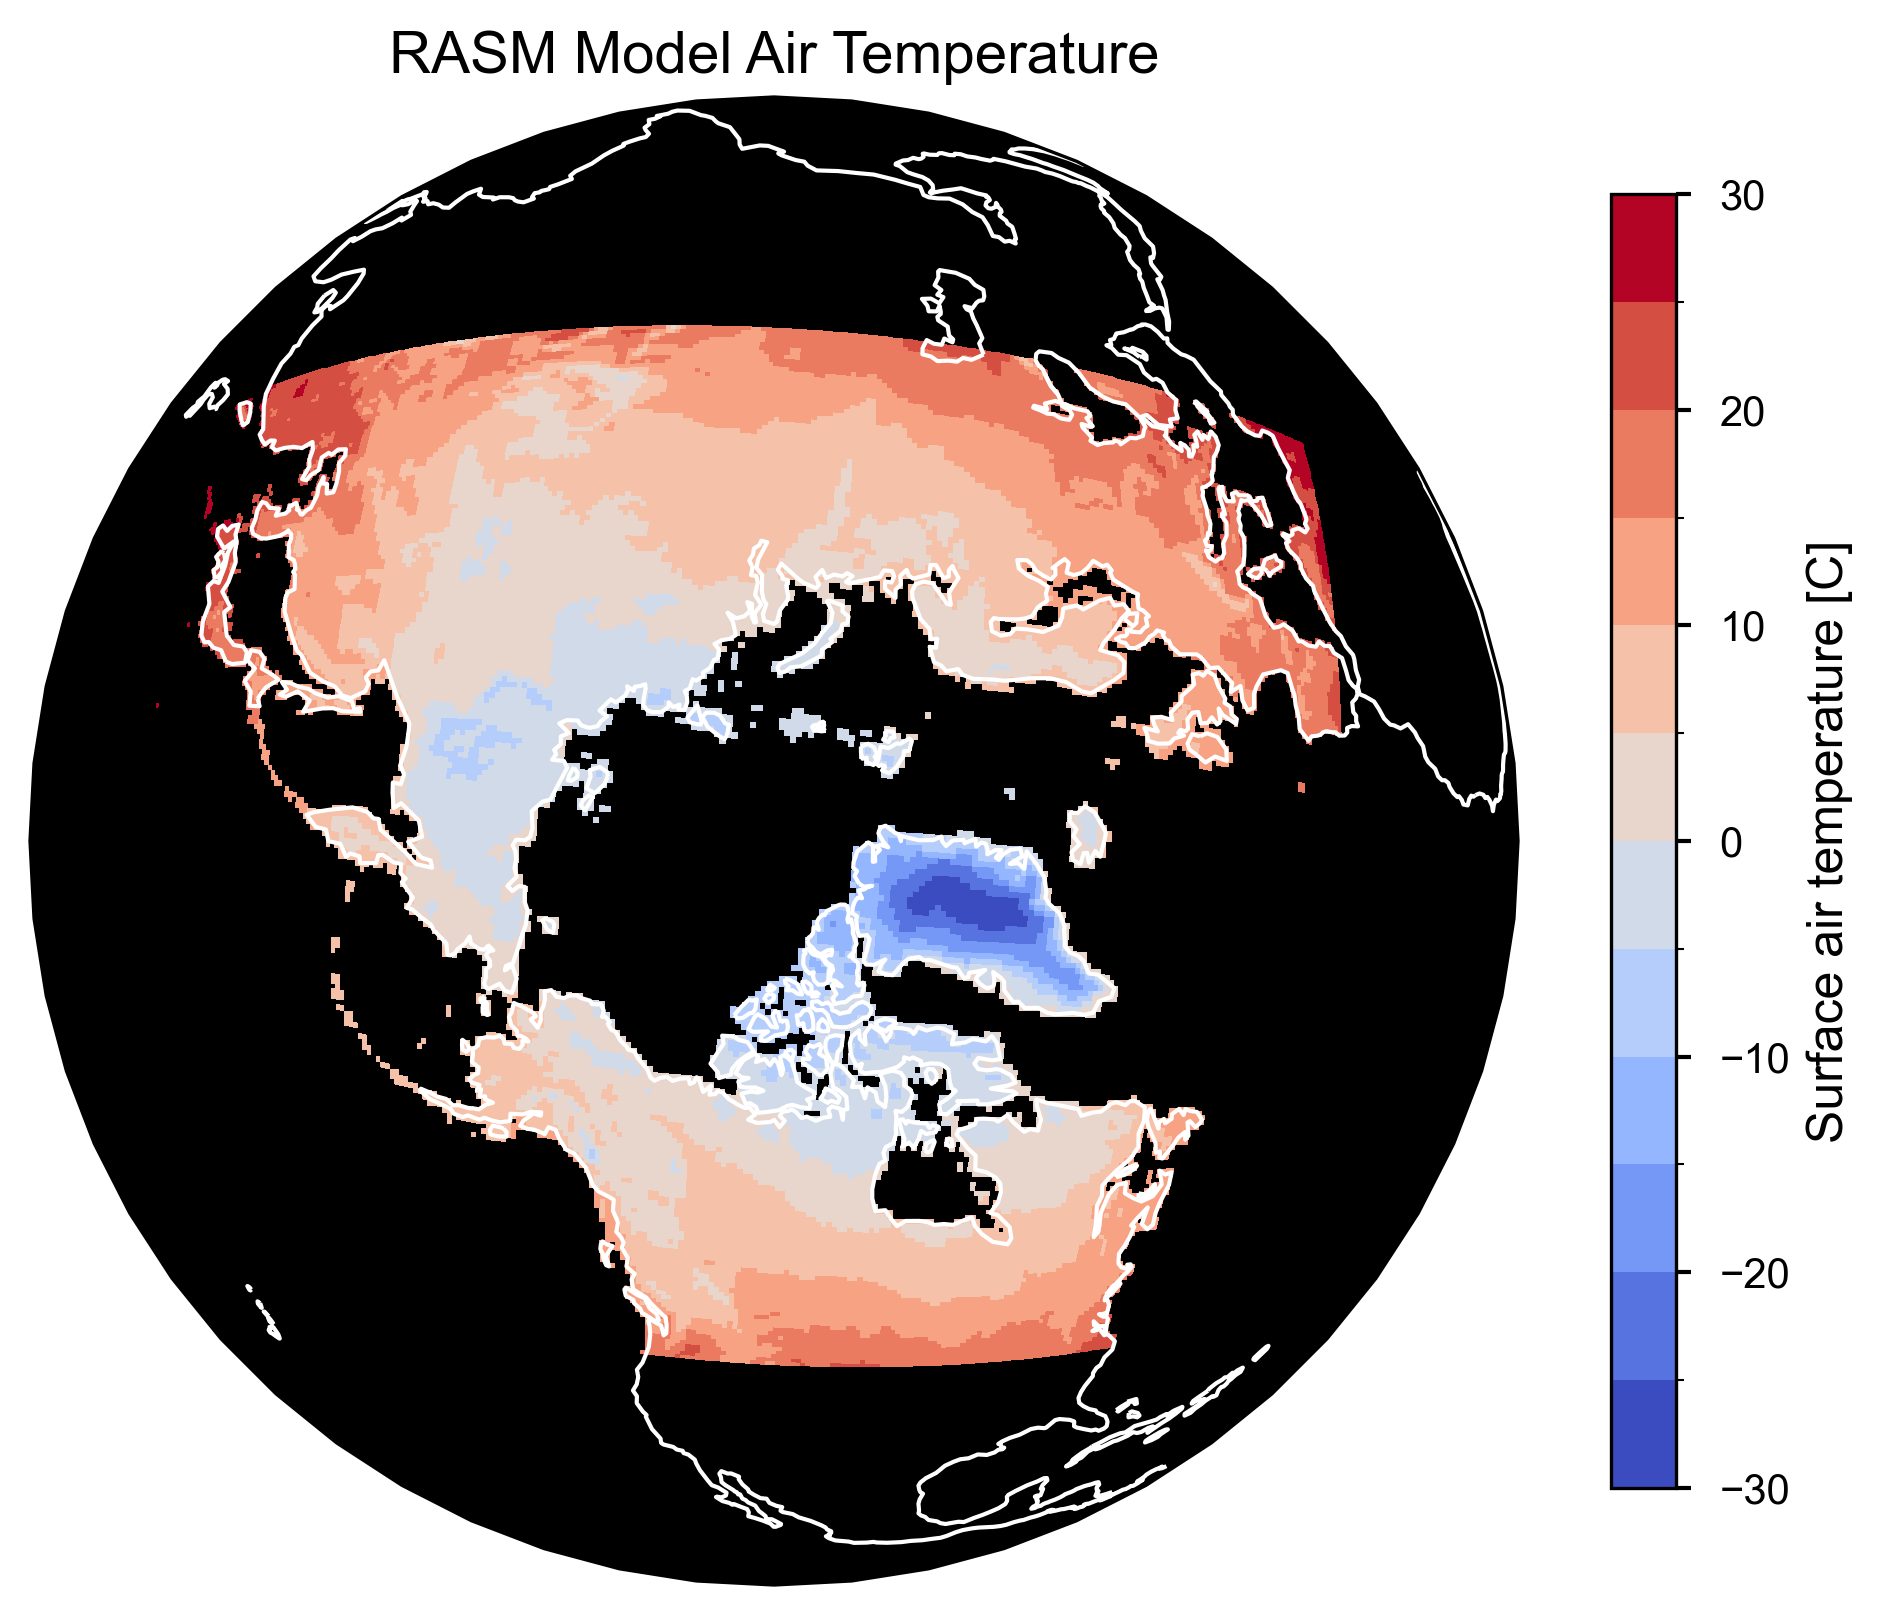

In [78]:
proj = ccrs.Orthographic(central_longitude=-110, central_latitude=90)
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': proj}, figsize=(8, 8))
ax.set_global()
sds['Tair'].plot.pcolormesh(
    levels=15,
    x="xc", y="yc",
    cmap='coolwarm',
    ax=ax, 
    transform=ccrs.PlateCarree(),
    cbar_kwargs={'shrink': 0.7}
)
ax.coastlines(color='white', linewidth=1.)
ax.set_title('RASM Model Air Temperature')
# Make the background black
ax.set_facecolor('black')
plt.show()